<a href="https://colab.research.google.com/github/vaibhav1234-pixel/taxi-price-prediction/blob/main/taxi_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Overview of Data

In [3]:
import pandas as pd
import numpy as np

# Loading data
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')

# # Taking a look on data
# train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [4]:
# datetime feature engineering

# converted into datetime format
train['tpep_pickup_datetime'] = pd.to_datetime(train.tpep_pickup_datetime)
train['tpep_dropoff_datetime'] = pd.to_datetime(train.tpep_dropoff_datetime)

# swaped pickup datetime with dropoff datetime if pickup datetime is greater than dropoff datetime
train[['tpep_pickup_datetime','tpep_dropoff_datetime']] = train[['tpep_pickup_datetime','tpep_dropoff_datetime']].mask( train['tpep_dropoff_datetime'] < train['tpep_pickup_datetime'], train[['tpep_dropoff_datetime','tpep_pickup_datetime']].values)

# created some usefull features out of date time features
train.loc[:, 'dropoff_hour'] = train['tpep_dropoff_datetime'].dt.hour
train.loc[:, 'pickup_hour'] = train['tpep_pickup_datetime'].dt.hour
train.loc[:, 'pickup_day'] = train['tpep_pickup_datetime'].dt.dayofweek

train.loc[:, 'pickup_weekday'] = train['tpep_pickup_datetime'].dt.day_name()
train.loc[:, 'pickup_date'] = train['tpep_pickup_datetime'].dt.day
train.loc[:, 'pickup_month'] = train['tpep_pickup_datetime'].dt.month

# trip duration in minutes
train['ride_duration'] = train['tpep_dropoff_datetime'] - train['tpep_pickup_datetime']
train['trip_duration'] = train['ride_duration'].dt.total_seconds()/60

train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'ride_duration'], axis=1)

# Feature Engineering

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# # removed logging features
train = train.drop(columns=['VendorID','payment_type'], axis=1)

# # Replaced unusual values with null values to impute later
train['RatecodeID'] = train['RatecodeID'].replace(99.0, np.nan)

# # Replaced null values of categorical feature with most frequent value (Used Mode Strategy. KNN Imputation was computationaly expensive)
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace(np.nan, 'N')

columns_to_impute = ['passenger_count','RatecodeID','congestion_surcharge','Airport_fee','trip_duration']
# columns_to_scale = ['trip_distance','trip_duration']

imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# scaler = Pipeline([
#     ('scaler', MinMaxScaler())
# ])

train[columns_to_impute] = imputer.fit_transform(train[columns_to_impute] )
# train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale] )
# scaling the data affects test score potential reasons can be overfitting or loss of information


ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['store_and_fwd_flag'])
    ]
)

train_prepared = ct.fit_transform(train)
column_names = ct.get_feature_names_out()
df = pd.DataFrame(train_prepared, columns = column_names )

train['onehot__store_and_fwd_flag_N'] = df['onehot__store_and_fwd_flag_N']
train['onehot__store_and_fwd_flag_Y'] = df['onehot__store_and_fwd_flag_Y']
train = train.drop(columns=['store_and_fwd_flag'], axis=1)
train.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,...,Airport_fee,dropoff_hour,pickup_hour,pickup_day,pickup_weekday,pickup_date,pickup_month,trip_duration,onehot__store_and_fwd_flag_N,onehot__store_and_fwd_flag_Y
0,1.0,2.14,1.0,120,9,2.5,7.165589,0.0,1.0,20.64,...,0.0,17,16,2,Wednesday,28,6,45.600000,1.0,0.0
1,1.0,2.70,1.0,15,215,3.5,6.067401,0.0,1.0,25.55,...,0.0,23,22,3,Thursday,29,6,63.433333,1.0,0.0
2,1.0,1.15,1.0,167,223,0.0,4.111547,0.0,1.0,17.64,...,0.0,11,10,4,Friday,30,6,53.650000,1.0,0.0
3,1.0,0.40,1.0,128,239,2.5,6.411079,0.0,1.0,12.80,...,0.0,14,13,3,Thursday,29,6,56.866667,1.0,0.0
4,3.0,1.10,1.0,203,52,1.0,4.769377,0.0,1.0,18.00,...,0.0,22,22,3,Thursday,29,6,18.833333,1.0,0.0


In [6]:
# Feature Engineering Test Set

# datetime
test['tpep_pickup_datetime'] = pd.to_datetime(test.tpep_pickup_datetime)
test['tpep_dropoff_datetime'] = pd.to_datetime(test.tpep_dropoff_datetime)

test[['tpep_pickup_datetime','tpep_dropoff_datetime']] = test[['tpep_pickup_datetime','tpep_dropoff_datetime']].mask( test['tpep_dropoff_datetime'] < test['tpep_pickup_datetime'], test[['tpep_dropoff_datetime','tpep_pickup_datetime']].values)

test.loc[:, 'dropoff_hour'] = test['tpep_dropoff_datetime'].dt.hour

test.loc[:, 'pickup_hour'] = test['tpep_pickup_datetime'].dt.hour

test.loc[:, 'pickup_day'] = test['tpep_pickup_datetime'].dt.dayofweek
# test.loc[:, 'pickup_date'] = test['tpep_pickup_datetime'].dt.day
# test.loc[:, 'pickup_month'] = test['tpep_pickup_datetime'].dt.month
# train.loc[:, 'pickup_weekday'] = train['tpep_pickup_datetime'].dt.day_name()

test['ride_duration'] = test['tpep_dropoff_datetime'] - test['tpep_pickup_datetime']
test['trip_duration'] = test['ride_duration'].dt.total_seconds()/60


test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'ride_duration'], axis=1)

# Feature Engineering

test = test.drop(columns=['VendorID','PULocationID', 'DOLocationID','payment_type'], axis=1)

test['RatecodeID'] = test['RatecodeID'].replace(99.0, np.nan)

test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace(np.nan, 'N')

columns_to_impute = ['passenger_count','RatecodeID','congestion_surcharge','Airport_fee',]
# columns_to_scale = ['trip_distance','trip_duration']

scaler = Pipeline([
    ('scaler', MinMaxScaler())
])

imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

test[columns_to_impute] = imputer.fit_transform(test[columns_to_impute] )
# test[columns_to_scale] = scaler.fit_transform(test[columns_to_scale] )


ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['store_and_fwd_flag'])
    ]
)

test_prepared = ct.fit_transform(test)
column_names = ct.get_feature_names_out()
test_df = pd.DataFrame(test_prepared, columns = column_names )

test['onehot__store_and_fwd_flag_N'] = test_df['onehot__store_and_fwd_flag_N']
test['onehot__store_and_fwd_flag_Y'] = test_df['onehot__store_and_fwd_flag_Y']

test = test.drop(columns=['store_and_fwd_flag'], axis=1)
test.head()

,passenger_count,trip_distance,RatecodeID,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,dropoff_hour,pickup_hour,pickup_day,trip_duration,onehot__store_and_fwd_flag_N,onehot__store_and_fwd_flag_Y
0,1.0,4.95,1.0,1.0,6.067612,0.0,1.0,2.5,0.0,0,0,3,4.000000,1.0,0.0
1,1.0,2.10,1.0,2.5,6.191269,0.0,1.0,2.5,0.0,17,17,4,8.500000,1.0,0.0
2,1.0,0.95,1.0,2.5,3.983872,0.0,1.0,2.5,0.0,19,18,3,66.733333,1.0,0.0
3,1.0,0.80,1.0,3.5,6.839341,0.0,1.0,2.5,0.0,21,21,4,12.450000,1.0,0.0
4,1.0,4.01,1.0,0.0,1.468943,0.0,1.0,0.0,0.0,15,14,3,28.383333,1.0,0.0


# EDA
#### Exploratory Data Analysis

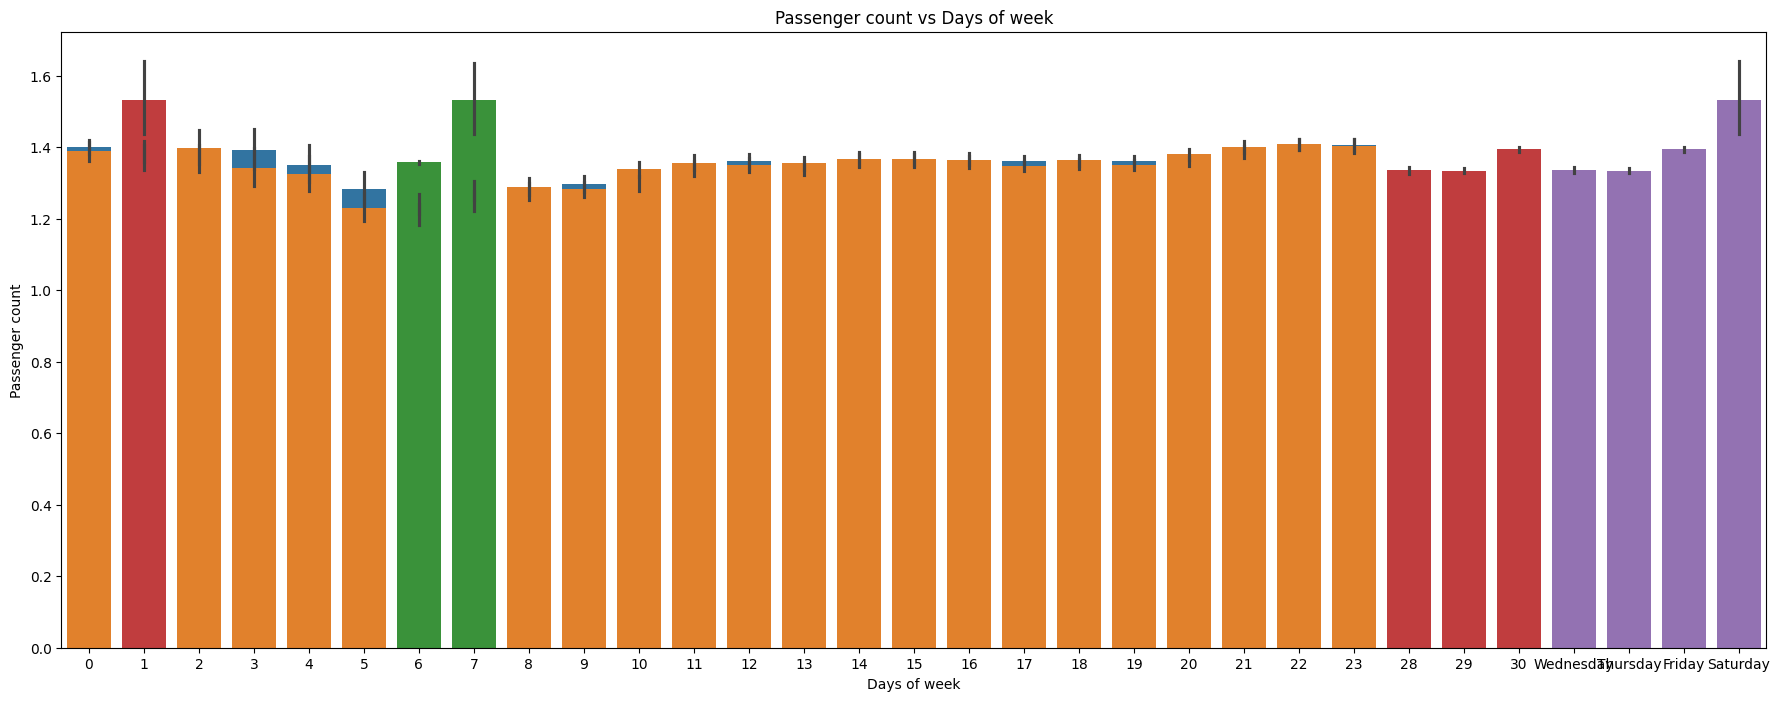

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Some more Datetime features to test



plt.figure(figsize=(22, 8))

# # Dropoff Hour
sns.barplot(y=train['passenger_count'], x=train['dropoff_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Passenger count')
plt.title ("Passenger count vs Hour of Day")

# # Pickup Hour

sns.barplot(y=train['passenger_count'], x=train['pickup_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Passenger count')
plt.title ("Passenger count vs Hour of Day")

# Day of Month
sns.barplot(y=train['passenger_count'], x=train['pickup_month'])
plt.xlabel('Month')
plt.ylabel('Passenger count')
plt.title ("Passenger count vs Month")

# # Date
sns.barplot(y=train['passenger_count'], x=train['pickup_date'])
plt.xlabel('Date')
plt.ylabel('Passenger count')
plt.title ("Passenger count vs Date")

# # WeekDay
sns.barplot(y=train['passenger_count'], x=train['pickup_weekday'])
plt.xlabel('Days of week')
plt.ylabel('Passenger count')
plt.title ("Passenger count vs Days of week")

# # # these datetime features do not posses enough data
train = train.drop(columns=['pickup_weekday','pickup_date', 'pickup_month'], axis=1)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


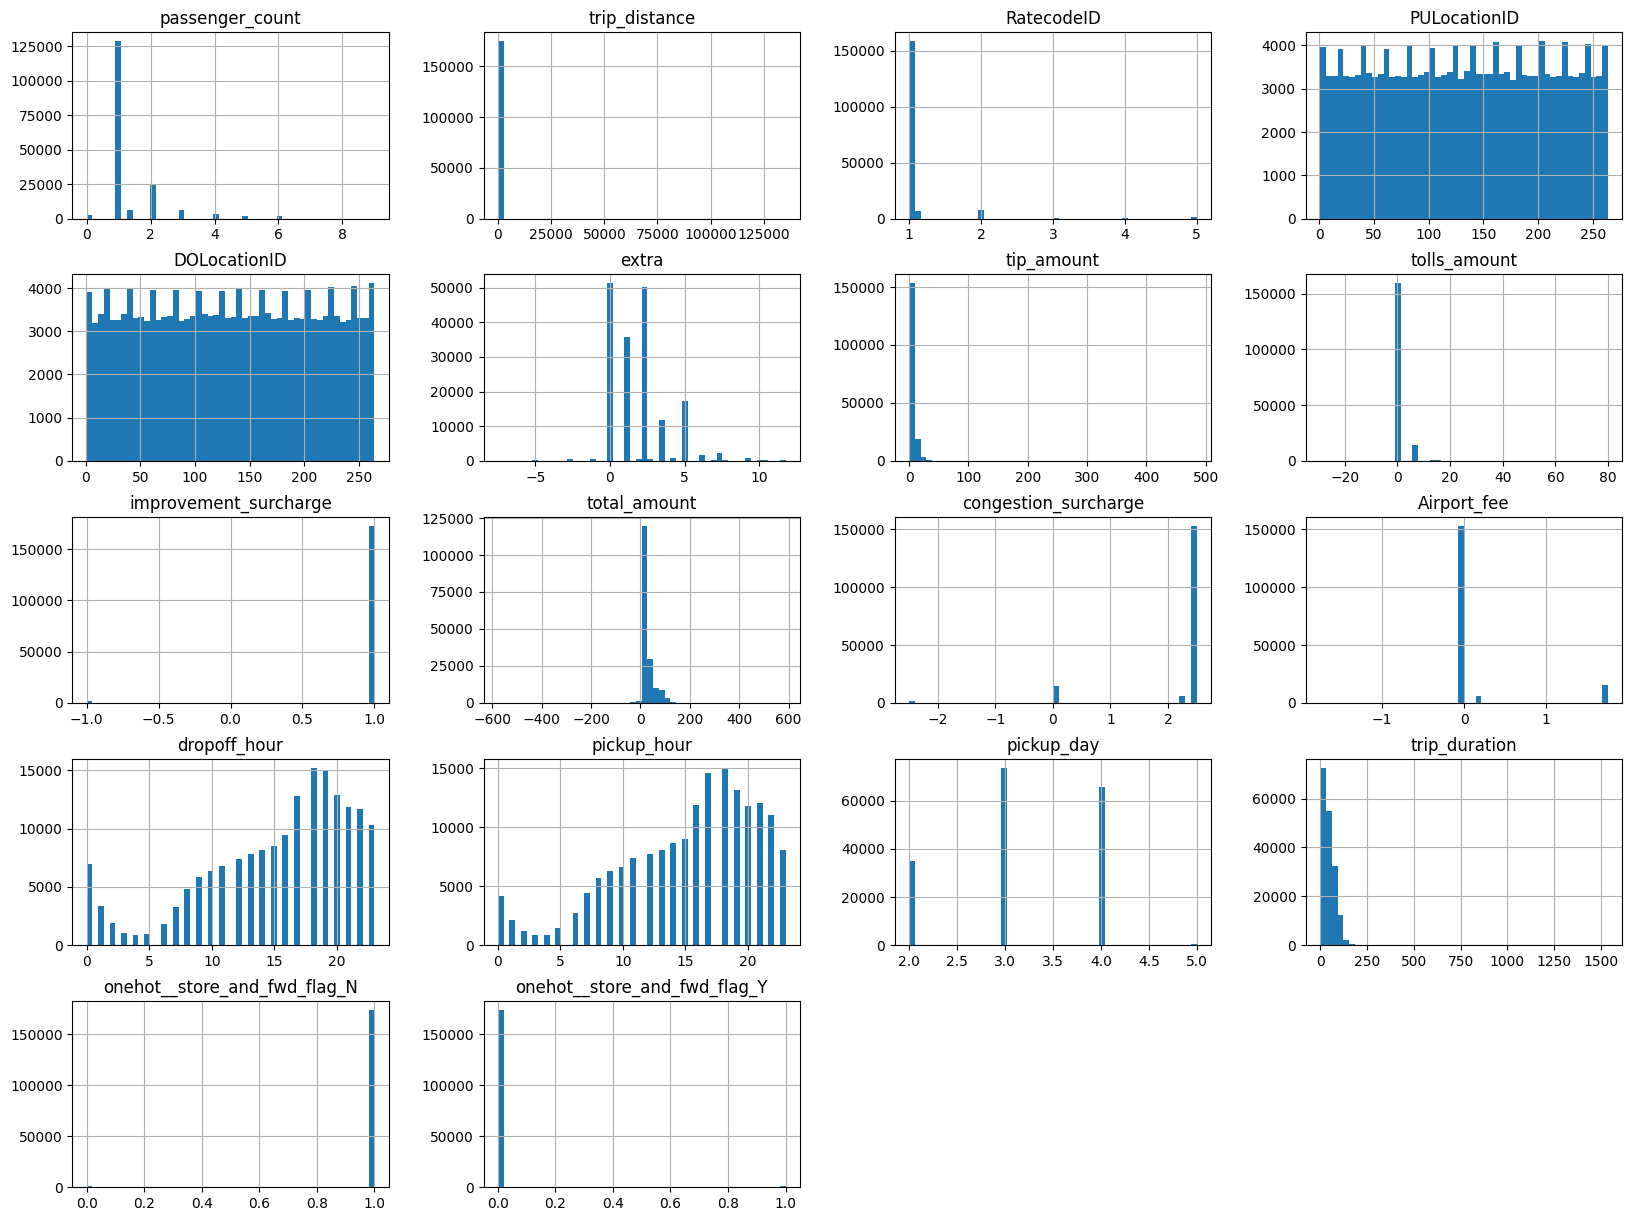

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


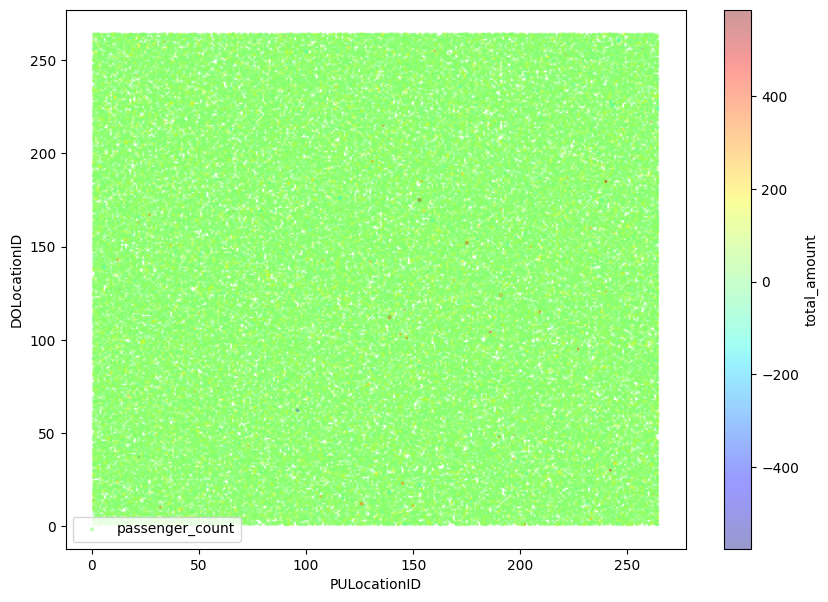

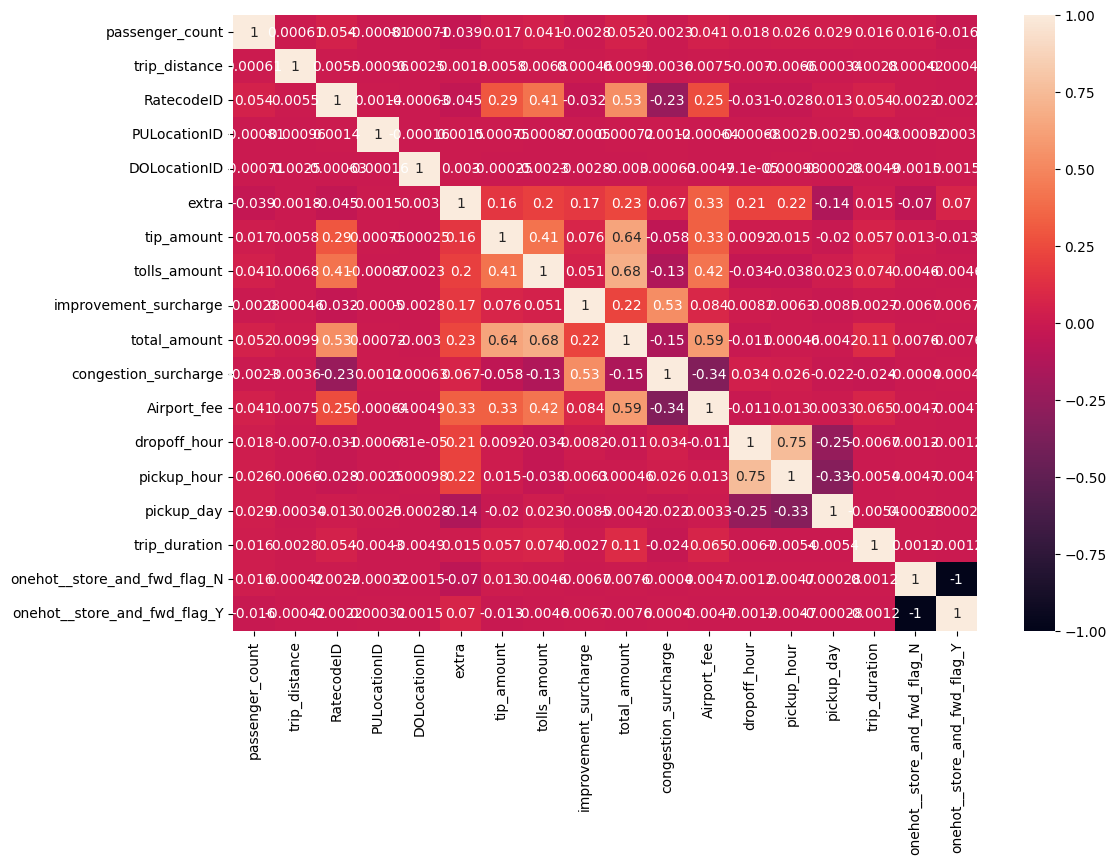

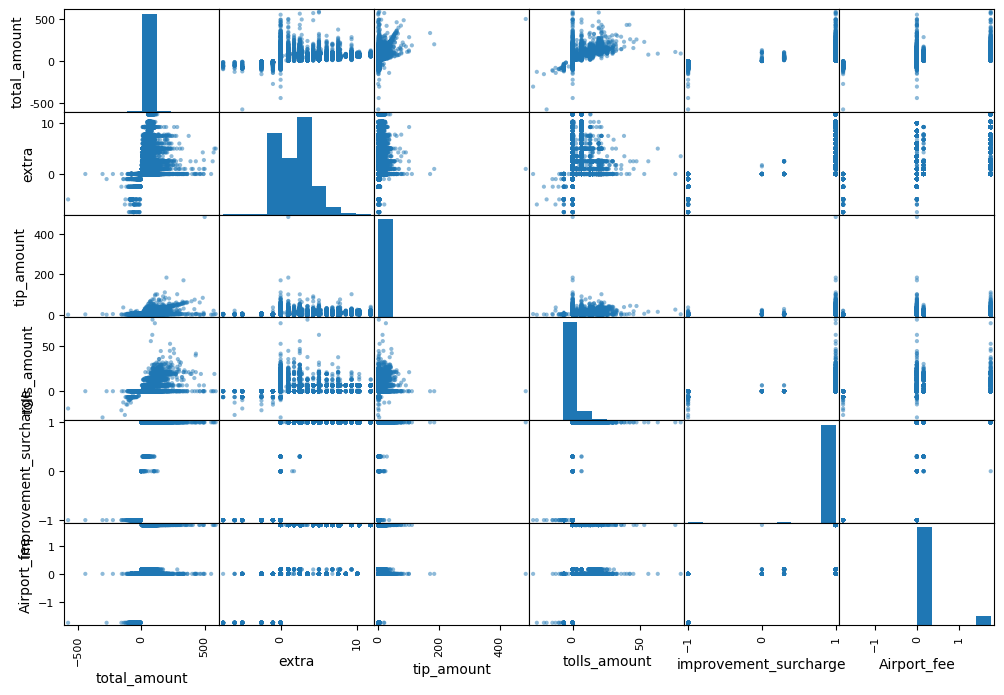

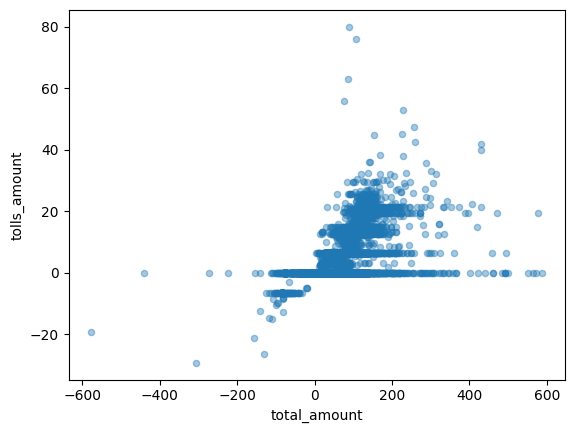

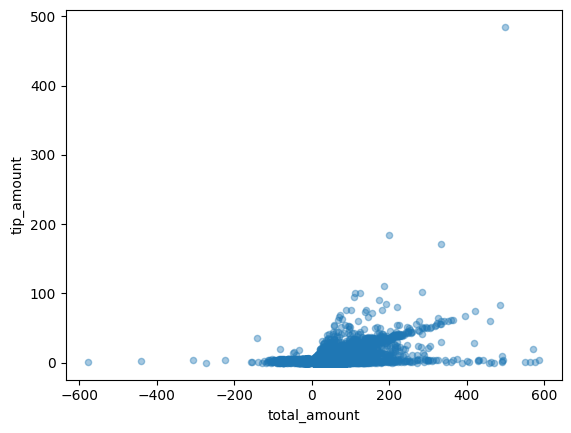

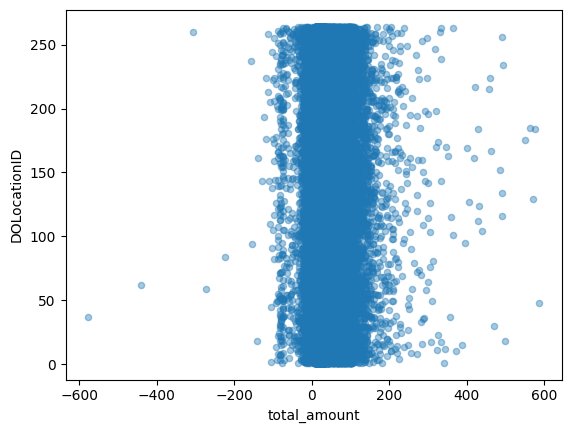

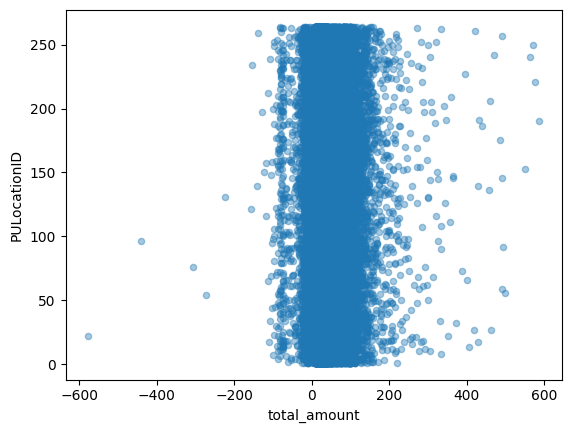

In [8]:


train.hist(bins=50, figsize=(20, 15))

# locations are not affecting the total amount
train.plot(kind='scatter', x='PULocationID', y='DOLocationID', alpha=0.4, s=train["passenger_count"], label="passenger_count", figsize=(10,7), c='total_amount', cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

# corelation matrix to understand relation between features and target variable
corr_matrix = train.corr()
corr_matrix["total_amount"].sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True)

# scatter plots of important features
from pandas.plotting import scatter_matrix
attributes = ['total_amount','extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'Airport_fee']
scatter_matrix(train[attributes], figsize=(12,8))

# magnifying important visuals from last plot
train.plot(kind='scatter', x='total_amount', y='tolls_amount', alpha=0.4) #  has some outliers and horizontal lines
train.plot(kind='scatter', x='total_amount', y='tip_amount', alpha=0.4) # there is some scatter at extremes
train.plot(kind='scatter', x='total_amount', y='DOLocationID', alpha=0.4) # does not affect total_amounts though have little scatter at right but seems uniform
train.plot(kind='scatter', x='total_amount', y='PULocationID', alpha=0.4) # same as DOLocationID


# # # Removed features that do not affect target variable
train = train.drop(columns=['PULocationID', 'DOLocationID'], axis=1)

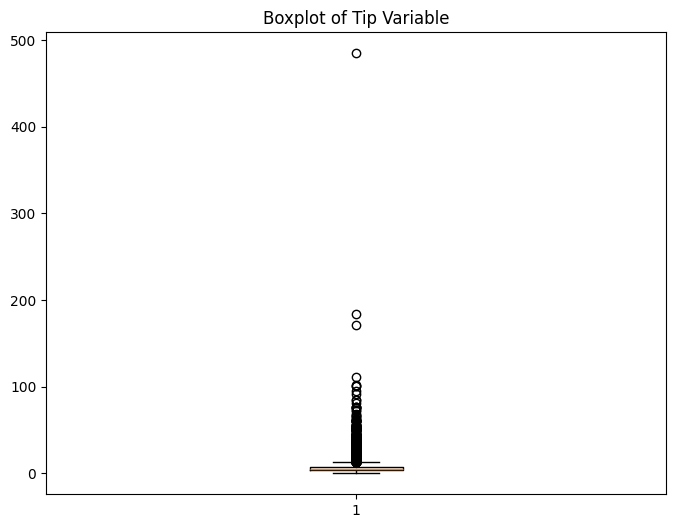

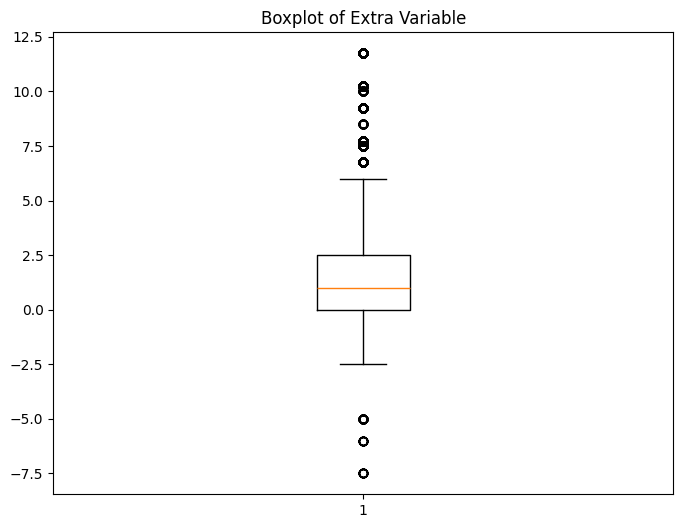

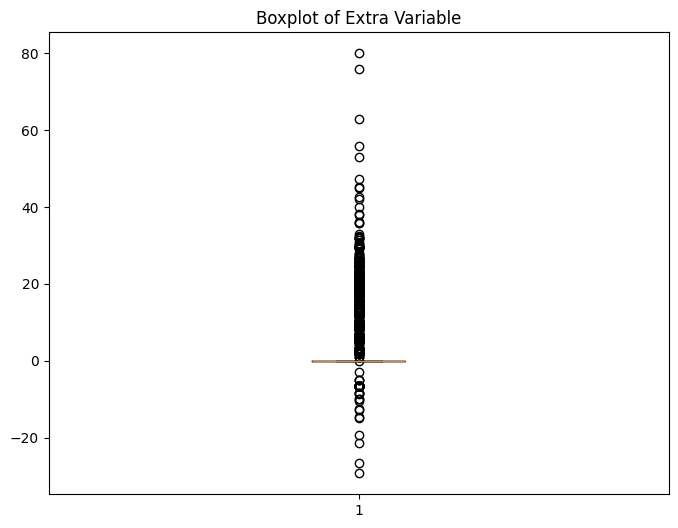

In [9]:
# # # dropping outliers worsen the result on test set
# train = train[train['total_amount'] >= 200]
# train = train[train['total_amount'] <= 500]
# target = train['total_amount']

plt.figure(figsize=(8, 6))
plt.boxplot(train['tip_amount'])
plt.title("Boxplot of Tip Variable")

plt.figure(figsize=(8, 6))
plt.boxplot(train['extra'])
plt.title("Boxplot of Extra Variable")

plt.figure(figsize=(8, 6))
plt.boxplot(train['tolls_amount'])
plt.title("Boxplot of Extra Variable")

plt.show()

# Selecting Model and Tuning Hyperparameters

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy import arange
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# with cross validation
X = train.drop('total_amount', axis=1)
y = train['total_amount']

# # with validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# hyperparameter tuning for ExtraTreesRegressor and RandomForestRegressor is done manually because of computational expense and time taking was in hours for given hardware. these are values tested -->
# n_estimators = [100, 200, 300, 400]
# max_depth = [10, 20, 30]
# min_samples_split = [2, 5, 7, 8, 10]
# min_samples_leaf = [1, 2]

# # Starting with simple regression model
# lin_reg = LinearRegression() # does not perform well

# dtr = DecisionTreeRegressor(max_depth=30, random_state= 42, min_samples_split=7) # 0.9299 on validation set


# # Second Best Model
# rfr = RandomForestRegressor(n_estimators=300, max_depth=30, random_state= 42, min_samples_split=7) # 0.9604 on validation set

# # BEST MODEL
etr = ExtraTreesRegressor(n_estimators=300,max_depth=30, random_state= 42, min_samples_split=7) # 0.9641 on validation set



# knn = KNeighborsRegressor(n_neighbors=7) # 0.8855 on validation set

# # hyperparameter search for knn regressor

# knn_param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11]  # You can customize this list
# }

# grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=10, scoring='r2')

# grid_search.fit(X, y)
# best_n_neighbors = grid_search.best_params_['n_neighbors']
# print("Best number of neighbors:", best_n_neighbors)

# # Here are some other regressor used
# xgb = xgb.XGBRegressor(
#     n_estimators=200,  # Number of boosting rounds
#     learning_rate=0.1,  # Step size shrinkage
#     max_depth=20,  # Maximum depth of individual trees
#     objective='reg:squarederror'  # Objective function for regression
# ) # 0.94 on validation set (approx.)

# # LGB is fastest model with 0.93 r2 score on test
# lgb = lgb.LGBMRegressor(
#     n_estimators=400,
#     learning_rate=0.1,
#     max_depth=30,
# )

# gradient_boost = GradientBoostingRegressor(
#     n_estimators=300,
#     learning_rate=0.01,
#     max_depth=10,
#     random_state=42
# ) # 0.95 on validation set (approx.)

# vr = VotingRegressor(estimators=[
#     ('xgboost', xgboost),
#     ('lgbm', lgbm),
#     ('gradient_boost', gradient_boost)
# ]) # 0.95 on validation set (approx.)


# # SVM is most expensive out of all models
# svr = SVR(kernel='linear', C=1.0, epsilon=0.2) # 0.89 (approx.) on validation set

# bagging = BaggingRegressor(dtr, n_estimators=300, random_state=42) # this model is roughly equivalent to random forest so it performs same 0.9603 r2 score


# # Checking Scores with
# scores = cross_val_score(etr, X, y, cv=5, scoring='r2')
# scores.mean()

# # or

etr.fit(X_train,y_train)
pred = etr.predict(X_val)
r2 = r2_score(y_val,pred)
r2




0.9641206179379781

# File Submission

In [11]:
etr.fit(X,y)

pred = etr.predict(test)

submission = pd.DataFrame(columns=['ID', 'total_amount'])

submission['ID'] = [i for i in range(1, len(pred)+1)]
submission['total_amount'] = pred
submission.to_csv('submission.csv', index=False)
submission.head()
submission.shape

(50000, 2)